# Experiment 2: Raw scan to scan registration

### Goal: use VICET to bound error in LIDAR odometry when initializing LOAM from a moving platform 

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-07-19 09:04:19.895785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 09:04:20.018424: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 09:04:20.425443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-19 09:04:20.425506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-19 09:04:21.319646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 09:04:21.320591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:04:21.320882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:04:21.321093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#load HD Map
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [131]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.0368229   0.08058061 -0.00672718  0.00550923 -0.01032399 -0.00310791], shape=(6,), dtype=float32)


In [264]:
#put HD Map and new scan in frame of raw keyframe scan
idx = 2690 #2750 
# idx = 1500 #test
skip = 40 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# #remove 4th column and center first scan about origin
# scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
# scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
# submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

2049


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [265]:
#run VICET
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 100, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 100, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [-0.13078275  0.02728868  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.1149  0.0238 -0.0023  0.0044 -0.0007  0.0005] 
 [ 0.0275 -0.0207 -0.0013  0.0008  0.0009 -0.0019]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.1058  0.0205 -0.0069  0.0078 -0.001   0.0008] 
 [ 0.054  -0.0362  0.002   0.0019  0.0012 -0.0032]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0979  0.0172 -0.0127  0.0103 -0.0011  0.0009] 
 [ 0.0753 -0.0482  0.0091  0.0031  0.0011 -0.0042]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0923  0.0144 -0.0187  0.0122 -0.0011  0.001 ] 
 [ 0.0936 -0.057   0.0175  0.0044  0.0009 -0.0049]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0883  0.0116 -0.0246  0.0135 -0.0011  0.0009] 
 [ 0.1089 -0.0635  0.0268  0.0057  0.0005 -0.0053]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.085   0.0088 -0.0299  0.0146 -0.001   0.0009] 
 [ 0.1214 -0.0681  0.0358  0.0069  0.0001 -0.0056]
~~~~

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [28]:
#run rigid ICET
it = ICET(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.01902512 -0.03123545  0.06054747  0.00668528  0.00534035 -0.01631089], shape=(6,), dtype=float32)


<IPython.core.display.Javascript object>


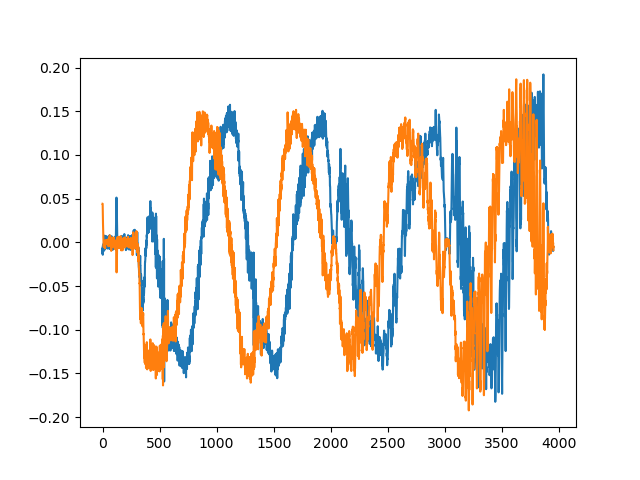

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.diff(poses[:,0,3]))
ax.plot(np.diff(poses[:,1,3]))

## Load LOAM Trajectory Initialzied From Moving Platform

In [250]:
# # start at 2400 (corner near tree) very obvious forward motion distortion
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag

# ## start at 2800
# # # rosbag play --clock -s 110.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# LOAM = np.load("results/LOAM/05_LOAM_start_from_2800_v1.npy")
# start_idx = 2810

# # rosbag play --clock -s 100.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
LOAM = np.load("results/LOAM/05_LOAM_start_from_2700_v1.npy")
start_idx = 2400

#  Plot on HD Map

In [340]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

fn = "results/LOAM/05_LOAM_start_from_2700_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2689 #2690

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(0), 0]).as_matrix() #was this for 678
rot_mat = R.from_euler('xyz', [np.deg2rad(10), np.deg2rad(31), np.deg2rad(5.5)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
# gt_lidarframe = (poses[start_idx] @ np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)
# gt_lidarframe = (np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T


gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix() #old
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


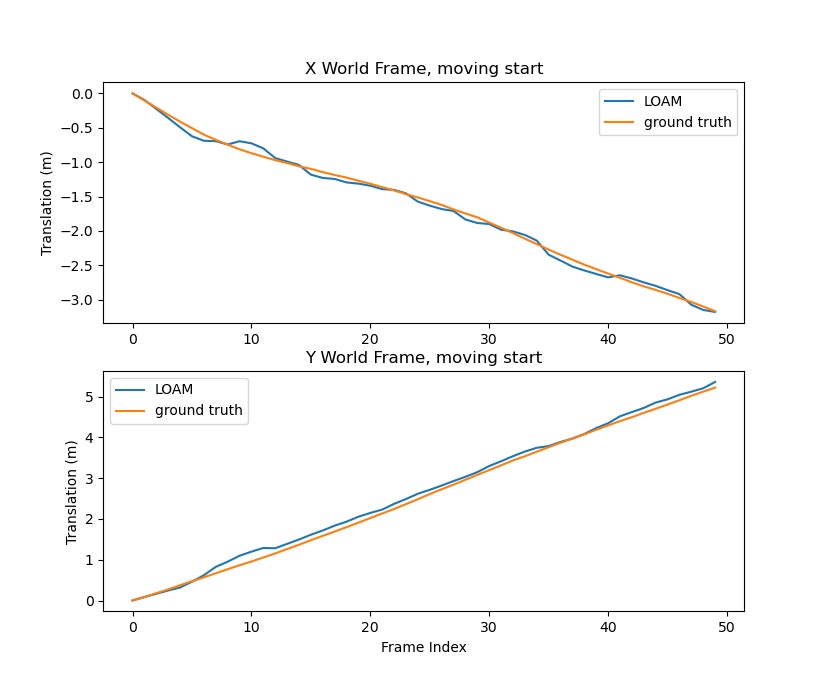

In [276]:
from matplotlib import pyplot as plt

view_len = 50 #ideal
# view_len = 100 #test
# view_len = len(LOAM_corr) #show all data

fig,ax = plt.subplots(2,1)
ax[0].set_title("X World Frame, moving start")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], label = 'ground truth')
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame, moving start")
ax[1].set_ylabel("Translation (m)")
ax[1].set_xlabel("Frame Index")
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM')
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], label = 'ground truth')
ax[1].legend(loc='best')

### Find ~50 frame region where VICET doesn't explode

In [291]:
from linear_corrector import LC #VICET
st = time.time()

runlen = 50
# start_idx = 2700
start_idx = 1800 #test

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_stds = np.zeros([runlen,12])
X_hist = np.zeros([runlen, 6]) #ICET/ NDT
X_hist_ICP = np.zeros([runlen, 6]) #ICP
raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #9 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    pc1 = np.load(fn1)
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc2 = np.load(fn2)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]

    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
#     submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx+idx] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = pc1, cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 55, niter = 50, draw = False, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A
    VICET_pred_stds[idx,:] = dc.pred_stds
#     np.save("results/VICET/VICET_constant_keyframe_05_start_from_1700_v1", A_hist)


 
 Frame # 1800 at 0.0002777576446533203 sec 
 

A0:
 [0.02116995 0.01271679 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0186  0.0125 -0.      0.      0.      0.0001] 
 [ 0.0001  0.0012 -0.0001 -0.0001 -0.     -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0165  0.0121 -0.0001  0.      0.      0.0001] 
 [ 0.0002  0.0022 -0.0002 -0.0001 -0.0001 -0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0147  0.0117 -0.0002  0.0001  0.      0.0002] 
 [ 0.0003  0.0032 -0.0002 -0.0002 -0.0001 -0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0133  0.0112 -0.0003  0.0001  0.0001  0.0002] 
 [ 0.0005  0.0041 -0.0002 -0.0002 -0.0001 -0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.012   0.0107 -0.0004  0.0001  0.0001  0.0003] 
 [ 0.0007  0.005  -0.0003 -0.0002 -0.0002 -0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.011   0.0101 -0.0004  0.0001  0.0001  0.0003] 
 [ 0.0009  0.0058

A: 
 [-0.0042  0.0231  0.0883 -0.0005 -0.0003 -0.0027] 
 [ 0.013  -0.0536 -0.125  -0.0113  0.0076 -0.0082]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0039  0.0255  0.0951 -0.0005 -0.0004 -0.0029] 
 [ 0.013  -0.0577 -0.1348 -0.0121  0.0082 -0.0092]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0034  0.0275  0.1002 -0.0006 -0.0003 -0.003 ] 
 [ 0.0125 -0.0613 -0.142  -0.0127  0.0084 -0.01  ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0029  0.0289  0.1044 -0.0006 -0.0002 -0.003 ] 
 [ 0.0117 -0.0643 -0.1481 -0.0132  0.0086 -0.0108]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0024  0.0298  0.108  -0.0006 -0.0002 -0.003 ] 
 [ 0.0108 -0.0667 -0.1534 -0.0136  0.0088 -0.0116]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0019  0.0303  0.111  -0.0007 -0.0002 -0.003 ] 
 [ 0.0098 -0.0686 -0.1578 -0.0139  0.009  -0.0123]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0013  0.0305  0.1136 -0.0007 -0.0003 -0.0029] 
 [ 0.0085 -0.07   -0.1616 -0.0141  0.0092 -0.013 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0283  0.0344  0.1076 -0.0167  0.0003 -0.0018] 
 [ 0.0244 -0.0872 -0.1927 -0.0266  0.0017 -0.0083]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0282  0.0351  0.1092 -0.0167  0.0003 -0.0018] 
 [ 0.0237 -0.0876 -0.1964 -0.0271  0.0017 -0.0086]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.028   0.0357  0.1106 -0.0168  0.0004 -0.0017] 
 [ 0.0229 -0.0877 -0.1996 -0.0276  0.0016 -0.0088]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0276  0.0362  0.1118 -0.0168  0.0005 -0.0017] 
 [ 0.0221 -0.0876 -0.2025 -0.028   0.0015 -0.0091]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0272  0.0365  0.1128 -0.0168  0.0006 -0.0016] 
 [ 0.0214 -0.0873 -0.2051 -0.0283  0.0015 -0.0094]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0267  0.0367  0.1137 -0.0168  0.0006 -0.0015] 
 [ 0.0207 -0.0869 -0.2073 -0.0286  0.0014 -0.0096]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0262  0.0368  0.1145 -0.0168  0.0007 -0.0014] 
 [ 0.02   -0.0863 -0.2093 -0.0288  0.0013 -0.0099]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0453 -0.0036  0.053  -0.0178 -0.0216  0.0003] 
 [-0.0703 -0.0773  0.0339 -0.0065 -0.0034  0.0148]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0463 -0.0016  0.0522 -0.0177 -0.0215  0.0002] 
 [-0.0715 -0.0797  0.0351 -0.0068 -0.0035  0.0149]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0473  0.0004  0.0514 -0.0176 -0.0215  0.0002] 
 [-0.0727 -0.082   0.0363 -0.007  -0.0036  0.0151]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0482  0.0023  0.0505 -0.0175 -0.0214  0.0002] 
 [-0.0739 -0.0843  0.0374 -0.0072 -0.0037  0.0152]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0492  0.0041  0.0497 -0.0174 -0.0214  0.0002] 
 [-0.075  -0.0863  0.0385 -0.0075 -0.0038  0.0153]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0501  0.0058  0.0488 -0.0173 -0.0213  0.0002] 
 [-0.0761 -0.0882  0.0396 -0.0077 -0.0039  0.0154]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.051   0.0074  0.048  -0.0172 -0.0212  0.0002] 
 [-0.0772 -0.0899  0.0406 -0.0079 -0.004   0.0154]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.0108  0.0091  0.032  -0.0096 -0.0015  0.0017] 
 [-0.0201 -0.0165 -0.0312 -0.0176 -0.0084 -0.0012]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0111  0.0095  0.0315 -0.0094 -0.0013  0.0018] 
 [-0.0206 -0.0171 -0.0311 -0.0179 -0.0086 -0.0013]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0114  0.0098  0.0311 -0.0093 -0.0012  0.0018] 
 [-0.021  -0.0177 -0.0311 -0.0181 -0.0088 -0.0013]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0117  0.0102  0.0307 -0.0092 -0.001   0.0019] 
 [-0.0215 -0.0182 -0.0311 -0.0184 -0.0091 -0.0014]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.012   0.0106  0.0304 -0.0091 -0.0009  0.0019] 
 [-0.0219 -0.0188 -0.0311 -0.0186 -0.0093 -0.0014]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0123  0.0109  0.03   -0.009  -0.0007  0.0019] 
 [-0.0223 -0.0194 -0.0311 -0.0189 -0.0095 -0.0015]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0126  0.0113  0.0297 -0.0089 -0.0006  0.002 ] 
 [-0.0227 -0.0199 -0.0312 -0.0191 -0.0097 -0.0015]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0181 -0.0656  0.0748 -0.0004 -0.001   0.0036] 
 [-0.0362  0.0285 -0.1238 -0.0213  0.0044  0.0009]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.018  -0.0664  0.0748 -0.0004 -0.0011  0.0037] 
 [-0.0364  0.0288 -0.1237 -0.0213  0.0044  0.0008]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0179 -0.0672  0.0748 -0.0004 -0.0011  0.0037] 
 [-0.0367  0.0291 -0.1236 -0.0213  0.0045  0.0008]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0179 -0.068   0.0748 -0.0004 -0.0011  0.0038] 
 [-0.0369  0.0294 -0.1234 -0.0213  0.0045  0.0007]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0178 -0.0688  0.0747 -0.0004 -0.0011  0.0038] 
 [-0.037   0.0297 -0.1233 -0.0213  0.0045  0.0006]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0177 -0.0696  0.0747 -0.0004 -0.0011  0.0038] 
 [-0.0373  0.03   -0.1231 -0.0213  0.0046  0.0006]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0176 -0.0703  0.0746 -0.0004 -0.0012  0.0039] 
 [-0.0375  0.0303 -0.1229 -0.0213  0.0046  0.0005]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [-0.058  -0.019   0.0748 -0.0119  0.0063 -0.0025] 
 [ 0.0897  0.0434 -0.1813 -0.0222  0.0131 -0.0207]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0579 -0.0193  0.0747 -0.0119  0.0063 -0.0024] 
 [ 0.0893  0.0429 -0.1812 -0.0222  0.0131 -0.0209]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0577 -0.0196  0.0746 -0.0118  0.0063 -0.0023] 
 [ 0.0888  0.0425 -0.1811 -0.0222  0.0131 -0.021 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0575 -0.0199  0.0745 -0.0118  0.0063 -0.0022] 
 [ 0.0883  0.0421 -0.181  -0.0223  0.0131 -0.0212]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0572 -0.0202  0.0744 -0.0118  0.0063 -0.0022] 
 [ 0.0878  0.0417 -0.1809 -0.0223  0.0131 -0.0213]

 
 Frame # 1807 at 45.00086832046509 sec 
 

A0:
 [0.01683126 0.00382164 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0189 -0.005   0.0242 -0.0031 -0.0018  0.0003] 
 [-0.0031 -0.0047 -0.0342 -0.0047  0.0013  0.0006]
~

A: 
 [ 0.0005 -0.0116  0.0097 -0.0071 -0.0045  0.001 ] 
 [ 0.0035 -0.0062  0.0046 -0.0021 -0.0009 -0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0007 -0.0132  0.0138 -0.0096 -0.0062  0.0013] 
 [ 0.0051 -0.0091  0.0056 -0.0028 -0.0011 -0.0012]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0017 -0.0139  0.017  -0.0116 -0.0075  0.0015] 
 [ 0.0065 -0.0119  0.0062 -0.0035 -0.0013 -0.0015]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0026 -0.0143  0.0199 -0.0131 -0.0086  0.0017] 
 [ 0.0076 -0.0145  0.0064 -0.0041 -0.0015 -0.0017]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0035 -0.0145  0.022  -0.0143 -0.0094  0.0018] 
 [ 0.0085 -0.0169  0.0065 -0.0047 -0.0017 -0.0019]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0044 -0.0146  0.0238 -0.0152 -0.01    0.002 ] 
 [ 0.0093 -0.019   0.0063 -0.0053 -0.0019 -0.0021]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0052 -0.015   0.0251 -0.0159 -0.0104  0.0021] 
 [ 0.01   -0.0208  0.0061 -0.0059 -0.0021 -0.0023]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.0409 -0.0367  0.0384 -0.0087 -0.0224  0.0039] 
 [-0.0342 -0.003  -0.0006 -0.004  -0.0115 -0.0072]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0426 -0.0367  0.0395 -0.0088 -0.0226  0.0041] 
 [-0.0368 -0.0043  0.     -0.0043 -0.0125 -0.0075]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0443 -0.0368  0.0403 -0.0089 -0.0228  0.0043] 
 [-0.0393 -0.0054  0.0005 -0.0045 -0.0133 -0.0078]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0458 -0.0367  0.041  -0.009  -0.0229  0.0046] 
 [-0.0416 -0.0065  0.0008 -0.0048 -0.0141 -0.0081]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0472 -0.0366  0.0415 -0.0091 -0.023   0.0048] 
 [-0.0436 -0.0078  0.001  -0.005  -0.0147 -0.0084]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0485 -0.0365  0.042  -0.0091 -0.023   0.005 ] 
 [-0.0456 -0.009   0.0011 -0.0052 -0.0153 -0.0087]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0497 -0.0365  0.0424 -0.0091 -0.023   0.0052] 
 [-0.0474 -0.0103  0.0012 -0.0054 -0.0159 -0.0089]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [-0.0309  0.0163 -0.0169 -0.0029 -0.0006 -0.0083] 
 [ 0.0469 -0.0413  0.0329  0.003  -0.0021 -0.0051]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0319  0.018  -0.0171 -0.0029 -0.0007 -0.0086] 
 [ 0.0486 -0.0439  0.0335  0.003  -0.0021 -0.0052]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0329  0.0198 -0.0173 -0.0029 -0.0007 -0.0089] 
 [ 0.0502 -0.0466  0.034   0.0031 -0.0021 -0.0053]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0338  0.0216 -0.0175 -0.0029 -0.0007 -0.0091] 
 [ 0.0517 -0.0493  0.0345  0.0032 -0.0021 -0.0054]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0346  0.0233 -0.0177 -0.003  -0.0008 -0.0094] 
 [ 0.0531 -0.0521  0.0349  0.0032 -0.0021 -0.0055]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0354  0.0252 -0.0179 -0.003  -0.0008 -0.0096] 
 [ 0.0544 -0.0551  0.0353  0.0033 -0.0021 -0.0056]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.036   0.027  -0.018  -0.003  -0.0008 -0.0098] 
 [ 0.0556 -0.0581  0.0357  0.0034 -0.0021 -0.0057]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0224  0.012   0.1146 -0.0038  0.0024 -0.0038] 
 [ 0.0615 -0.0138 -0.22   -0.0206  0.0202 -0.0131]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0231  0.0128  0.1144 -0.0038  0.0025 -0.0039] 
 [ 0.0631 -0.0156 -0.2199 -0.0207  0.0202 -0.0134]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0238  0.0137  0.1141 -0.0038  0.0025 -0.004 ] 
 [ 0.0645 -0.0174 -0.2198 -0.0208  0.0202 -0.0136]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0245  0.0145  0.1139 -0.0037  0.0025 -0.004 ] 
 [ 0.0659 -0.0191 -0.2197 -0.0209  0.0202 -0.0138]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0251  0.0153  0.1136 -0.0037  0.0025 -0.0041] 
 [ 0.0671 -0.0208 -0.2196 -0.021   0.0201 -0.014 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0258  0.0161  0.1133 -0.0036  0.0026 -0.0041] 
 [ 0.0683 -0.0224 -0.2194 -0.021   0.0201 -0.0142]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0264  0.0169  0.113  -0.0036  0.0026 -0.0042] 
 [ 0.0694 -0.0241 -0.2192 -0.0211  0.0201 -0.0144]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [ 0.0204 -0.1009  0.0872 -0.0075 -0.0021  0.0046] 
 [-0.0599  0.0241 -0.1585 -0.0321  0.0154  0.0073]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0202 -0.1018  0.0864 -0.0074 -0.002   0.0047] 
 [-0.0596  0.0254 -0.1578 -0.0323  0.0153  0.0073]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.02   -0.1027  0.0856 -0.0073 -0.0019  0.0047] 
 [-0.0592  0.0267 -0.1571 -0.0326  0.0152  0.0072]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0198 -0.1036  0.0849 -0.0072 -0.0019  0.0048] 
 [-0.0588  0.028  -0.1564 -0.0328  0.0151  0.0072]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0196 -0.1045  0.0841 -0.007  -0.0018  0.0048] 
 [-0.0584  0.0293 -0.1557 -0.033   0.0151  0.0071]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0193 -0.1054  0.0834 -0.0069 -0.0017  0.0049] 
 [-0.058   0.0305 -0.155  -0.0333  0.015   0.0071]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0191 -0.1062  0.0827 -0.0068 -0.0016  0.0049] 
 [-0.0576  0.0318 -0.1543 -0.0335  0.0149  0.007 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [-0.0003  0.0307  0.0946  0.0037 -0.005  -0.0002] 
 [ 0.0162 -0.0854 -0.1063 -0.0295 -0.0035 -0.0167]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0001  0.03    0.0946  0.0038 -0.005  -0.0001] 
 [ 0.0155 -0.0849 -0.1063 -0.0296 -0.0035 -0.0168]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0005  0.0294  0.0947  0.0038 -0.005   0.    ] 
 [ 0.0148 -0.0843 -0.1064 -0.0296 -0.0035 -0.017 ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.001   0.0288  0.0947  0.0038 -0.005   0.0001] 
 [ 0.0142 -0.0838 -0.1065 -0.0296 -0.0035 -0.0172]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0015  0.0281  0.0947  0.0038 -0.005   0.0003] 
 [ 0.0135 -0.0833 -0.1065 -0.0296 -0.0035 -0.0173]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0019  0.0275  0.0947  0.0038 -0.005   0.0004] 
 [ 0.0129 -0.0827 -0.1065 -0.0296 -0.0035 -0.0175]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0024  0.0269  0.0947  0.0038 -0.005   0.0005] 
 [ 0.0123 -0.0821 -0.1065 -0.0297 -0.0035 -0.0176]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

A: 
 [ 0.0031 -0.0109  0.0537 -0.006  -0.0032  0.0068] 
 [-0.0442 -0.0963 -0.0538 -0.005   0.0066 -0.0133]

 
 Frame # 1815 at 97.65343618392944 sec 
 

A0:
 [ 0.01516276 -0.01960467  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0161 -0.0317  0.0181 -0.0011 -0.0002  0.0011] 
 [-0.0041  0.0073 -0.0195 -0.0016  0.0015  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0166 -0.0427  0.0327 -0.002  -0.0004  0.0021] 
 [-0.0077  0.0147 -0.0351 -0.0029  0.0028  0.001 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.017  -0.0527  0.0444 -0.0027 -0.0005  0.003 ] 
 [-0.0111  0.0214 -0.0475 -0.004   0.0037  0.0014]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0172 -0.0617  0.0541 -0.0032 -0.0006  0.0038] 
 [-0.0141  0.0272 -0.0579 -0.0049  0.0045  0.0018]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0172 -0.07    0.0621 -0.0037 -0.0007  0.0046] 
 [-0.0168  0.0332 -0.0666 -0.0056  0.0051  0

A: 
 [ 0.0002  0.0078  0.0912 -0.0058  0.008  -0.0018] 
 [ 0.0185 -0.0068 -0.1347 -0.0153  0.002  -0.0031]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0001  0.0092  0.1014 -0.0061  0.0084 -0.002 ] 
 [ 0.0208 -0.0091 -0.1543 -0.0169  0.0027 -0.0035]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0006  0.0106  0.1101 -0.0063  0.0087 -0.0021] 
 [ 0.0228 -0.0113 -0.1724 -0.0185  0.0034 -0.0039]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.001   0.012   0.1175 -0.0063  0.009  -0.0022] 
 [ 0.0246 -0.0136 -0.189  -0.0199  0.004  -0.0043]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0015  0.0129  0.1238 -0.0063  0.0092 -0.0022] 
 [ 0.0264 -0.0151 -0.2035 -0.0213  0.0045 -0.0047]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.002   0.0137  0.1292 -0.0063  0.0095 -0.0022] 
 [ 0.028  -0.0164 -0.2165 -0.0225  0.0049 -0.0051]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0025  0.0144  0.1337 -0.0062  0.0097 -0.0022] 
 [ 0.0295 -0.0174 -0.2281 -0.0236  0.0052 -0.0055]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0149 -0.0295  0.1826 -0.0072  0.0031  0.0014] 
 [-0.0216 -0.1104 -0.3124 -0.0358  0.0019 -0.0067]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0152 -0.0299  0.1852 -0.0072  0.0031  0.0015] 
 [-0.0237 -0.1122 -0.3176 -0.0363  0.002  -0.0069]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0156 -0.0302  0.1875 -0.0072  0.0031  0.0015] 
 [-0.0256 -0.1137 -0.3221 -0.0367  0.0022 -0.0071]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0159 -0.0306  0.1895 -0.0072  0.0031  0.0016] 
 [-0.0275 -0.1149 -0.3261 -0.0371  0.0023 -0.0073]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0163 -0.031   0.1911 -0.0072  0.0031  0.0017] 
 [-0.0292 -0.1159 -0.3295 -0.0374  0.0025 -0.0075]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0166 -0.0314  0.1925 -0.0071  0.0031  0.0017] 
 [-0.0308 -0.1167 -0.3324 -0.0376  0.0026 -0.0077]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0169 -0.0318  0.1937 -0.0071  0.0031  0.0018] 
 [-0.0322 -0.1176 -0.335  -0.0379  0.0027 -0.0078]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [ 0.0011 -0.0306  0.1157 -0.0104 -0.0107  0.0002] 
 [-0.0155 -0.0605 -0.1075 -0.0143  0.0069  0.0003]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0006 -0.0299  0.1155 -0.0103 -0.0106  0.0001] 
 [-0.0159 -0.0634 -0.1076 -0.0146  0.0068  0.0004]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0002 -0.0293  0.1153 -0.0102 -0.0105  0.    ] 
 [-0.0164 -0.0662 -0.1077 -0.0149  0.0066  0.0004]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0003 -0.0286  0.115  -0.0101 -0.0104 -0.    ] 
 [-0.0168 -0.0691 -0.1078 -0.0152  0.0065  0.0005]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0007 -0.0279  0.1147 -0.01   -0.0103 -0.0001] 
 [-0.0173 -0.072  -0.1079 -0.0155  0.0063  0.0005]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0011 -0.0272  0.1144 -0.0099 -0.0102 -0.0001] 
 [-0.0178 -0.0748 -0.108  -0.0157  0.0062  0.0006]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0014 -0.0267  0.1141 -0.0098 -0.0101 -0.0002] 
 [-0.0184 -0.0774 -0.108  -0.016   0.0061  0.0007]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [ 0.0202 -0.0448  0.0621 -0.0116 -0.014   0.0033] 
 [ 0.0121 -0.0035  0.0097 -0.0029 -0.0031 -0.0168]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0203 -0.0458  0.062  -0.0116 -0.014   0.0034] 
 [ 0.0118 -0.0022  0.0098 -0.0029 -0.0031 -0.017 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0205 -0.0468  0.0619 -0.0116 -0.0139  0.0035] 
 [ 0.0116 -0.0009  0.0098 -0.003  -0.0032 -0.0172]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0207 -0.0478  0.0618 -0.0115 -0.0139  0.0036] 
 [ 0.0114  0.0003  0.0097 -0.0031 -0.0032 -0.0173]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0208 -0.0488  0.0618 -0.0115 -0.0139  0.0037] 
 [ 0.0111  0.0015  0.0097 -0.0032 -0.0033 -0.0175]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.021  -0.0498  0.0617 -0.0115 -0.0138  0.0038] 
 [ 0.0109  0.0027  0.0096 -0.0032 -0.0033 -0.0177]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0211 -0.0508  0.0616 -0.0114 -0.0138  0.0039] 
 [ 0.0107  0.0039  0.0096 -0.0033 -0.0033 -0.0178]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [ 0.0338 -0.0053  0.0506 -0.0095 -0.0062  0.0056] 
 [ 0.0116  0.0013 -0.0155 -0.0069 -0.0061 -0.0175]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0345 -0.0057  0.0507 -0.0095 -0.0062  0.0058] 
 [ 0.0111  0.0025 -0.0157 -0.0069 -0.0061 -0.0177]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0351 -0.0061  0.0508 -0.0095 -0.0062  0.0059] 
 [ 0.0106  0.0036 -0.0158 -0.0069 -0.0061 -0.0179]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0357 -0.0065  0.0509 -0.0095 -0.0061  0.006 ] 
 [ 0.0102  0.0048 -0.016  -0.0068 -0.0061 -0.018 ]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0362 -0.0069  0.051  -0.0095 -0.0061  0.0061] 
 [ 0.0098  0.0057 -0.0161 -0.0068 -0.0061 -0.0182]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0368 -0.0073  0.0511 -0.0095 -0.0061  0.0062] 
 [ 0.0095  0.0066 -0.0163 -0.0068 -0.0061 -0.0183]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0373 -0.0077  0.0512 -0.0095 -0.0061  0.0063] 
 [ 0.0091  0.0076 -0.0164 -0.0068 -0.0061 -0.0185]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [-0.0098  0.0435  0.0724 -0.0079  0.0001 -0.01  ] 
 [-0.0808 -0.3305 -0.121  -0.0217  0.0012  0.019 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0097  0.0469  0.0723 -0.0079  0.0001 -0.0103] 
 [-0.0828 -0.3384 -0.1211 -0.0217  0.0012  0.0193]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0096  0.0503  0.0722 -0.0079  0.0002 -0.0105] 
 [-0.0848 -0.3466 -0.1211 -0.0218  0.0011  0.0196]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0094  0.0538  0.0721 -0.0078  0.0002 -0.0107] 
 [-0.0868 -0.3547 -0.1212 -0.0218  0.0011  0.0198]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0093  0.0571  0.072  -0.0078  0.0002 -0.0109] 
 [-0.0888 -0.3627 -0.1212 -0.0218  0.0011  0.0201]

 
 Frame # 1822 at 143.50582337379456 sec 
 

A0:
 [-0.00267469 -0.00858794  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0017 -0.0096  0.0174 -0.0024 -0.0005  0.0004] 
 [ 0.0001 -0.0224 -0.0232 -0.0045  0.00

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0084 -0.0164  0.0151 -0.0038 -0.003   0.0004] 
 [ 0.0023 -0.002  -0.0171 -0.0018  0.0018 -0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0067 -0.0174  0.0266 -0.0067 -0.0053  0.0008] 
 [ 0.0041 -0.0036 -0.0297 -0.0034  0.003  -0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0053 -0.0175  0.0357 -0.0089 -0.0071  0.0012] 
 [ 0.0054 -0.005  -0.0404 -0.005   0.004  -0.0038]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.004  -0.017   0.0415 -0.0104 -0.0084  0.0016] 
 [ 0.0065 -0.0069 -0.0475 -0.0068  0.0044 -0.0047]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.003  -0.0167  0.0458 -0.0115 -0.0092  0.0021] 
 [ 0.0075 -0.0085 -0.0522 -0.0085  0.0046 -0.0057]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.002  -0.0166  0.049  -0.0123 -0.0099  0.0025] 
 [ 0.0082 -0.0096 -0.0561 -0.0099  0.0047 -0.0067]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0011 -0.0167  0.051  -0.0128 -0.0104  0.0029] 
 [ 0.0087 -0.0104 -0.0589 -0.0113  0.0047 -0.0076]
~~~~~~

A: 
 [-0.0099 -0.005   0.0663 -0.0104 -0.0075  0.0014] 
 [ 0.0096 -0.0606 -0.0539 -0.0098 -0.0084 -0.0041]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.01   -0.005   0.0691 -0.0108 -0.0077  0.0015] 
 [ 0.0085 -0.0652 -0.0561 -0.0103 -0.009  -0.0043]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0102 -0.0051  0.0714 -0.0111 -0.0078  0.0016] 
 [ 0.007  -0.0695 -0.0577 -0.0108 -0.0095 -0.0044]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0101 -0.0051  0.0732 -0.0113 -0.0078  0.0017] 
 [ 0.0054 -0.0736 -0.059  -0.0111 -0.0099 -0.0045]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0101 -0.005   0.0745 -0.0115 -0.0079  0.0017] 
 [ 0.0031 -0.0773 -0.0597 -0.0115 -0.0103 -0.0045]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.01   -0.005   0.0756 -0.0116 -0.0079  0.0017] 
 [ 0.0008 -0.0805 -0.0604 -0.0118 -0.0107 -0.0044]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0098 -0.0049  0.0765 -0.0117 -0.0079  0.0018] 
 [-0.0014 -0.0836 -0.0609 -0.012  -0.011  -0.0044]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.0222  0.0311  0.0815 -0.0043 -0.0044 -0.0021] 
 [-0.0167 -0.1856 -0.0328 -0.0099 -0.0094  0.0054]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0229  0.0344  0.0819 -0.0043 -0.0043 -0.0023] 
 [-0.0194 -0.1945 -0.0327 -0.01   -0.0095  0.0058]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0236  0.0375  0.0823 -0.0043 -0.0043 -0.0026] 
 [-0.021  -0.2037 -0.0327 -0.0101 -0.0096  0.0061]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0243  0.0397  0.0825 -0.0043 -0.0043 -0.0028] 
 [-0.0227 -0.2114 -0.0328 -0.0102 -0.0097  0.0064]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.025   0.0419  0.0827 -0.0043 -0.0043 -0.0031] 
 [-0.0239 -0.2191 -0.0327 -0.0103 -0.0098  0.0066]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0256  0.0441  0.0829 -0.0043 -0.0043 -0.0033] 
 [-0.0254 -0.2267 -0.0328 -0.0103 -0.0098  0.0069]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0264  0.0462  0.083  -0.0043 -0.0043 -0.0035] 
 [-0.0266 -0.2339 -0.0328 -0.0104 -0.0099  0.0071]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.003  -0.0173  0.0722 -0.0046  0.0011 -0.0019] 
 [-0.0251 -0.0452 -0.0899 -0.0101  0.0075  0.0054]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0028 -0.0169  0.0718 -0.0045  0.001  -0.002 ] 
 [-0.0261 -0.0473 -0.0893 -0.0101  0.0076  0.0056]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0026 -0.0165  0.0714 -0.0045  0.001  -0.0021] 
 [-0.0271 -0.0494 -0.0886 -0.0102  0.0077  0.0058]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0024 -0.016   0.071  -0.0045  0.0009 -0.0022] 
 [-0.028  -0.0514 -0.0879 -0.0102  0.0079  0.0059]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0023 -0.0156  0.0706 -0.0044  0.0009 -0.0022] 
 [-0.0289 -0.0534 -0.0872 -0.0102  0.008   0.006 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0021 -0.0152  0.0701 -0.0044  0.0008 -0.0023] 
 [-0.0296 -0.0554 -0.0864 -0.0103  0.0081  0.0061]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.002  -0.0148  0.0697 -0.0044  0.0008 -0.0024] 
 [-0.0303 -0.0575 -0.0856 -0.0103  0.0082  0.0062]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.0048 -0.0839  0.1554 -0.0118  0.0024  0.0077] 
 [ 0.0172  0.0971 -0.3238 -0.0252  0.0157 -0.0184]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.004  -0.0857  0.1547 -0.0117  0.0025  0.008 ] 
 [ 0.0169  0.1013 -0.3233 -0.0255  0.0155 -0.0187]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0032 -0.0877  0.1539 -0.0115  0.0026  0.0082] 
 [ 0.0167  0.1056 -0.3226 -0.0258  0.0154 -0.0191]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0025 -0.0896  0.1531 -0.0114  0.0028  0.0085] 
 [ 0.0165  0.1098 -0.3219 -0.026   0.0152 -0.0194]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0017 -0.0915  0.1523 -0.0113  0.0029  0.0087] 
 [ 0.0164  0.1141 -0.3213 -0.0263  0.0151 -0.0197]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0016 -0.0929  0.1516 -0.0111  0.003   0.0089] 
 [ 0.0177  0.1178 -0.3207 -0.0266  0.0149 -0.02  ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0009 -0.0947  0.1508 -0.011   0.0031  0.0092] 
 [ 0.0179  0.1219 -0.32   -0.0268  0.0148 -0.0204]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.0321  0.0288  0.0944 -0.0191 -0.0115  0.0019] 
 [-0.0811 -0.1953 -0.0845 -0.0116  0.0071 -0.0053]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.033   0.0313  0.0945 -0.0191 -0.0115  0.0019] 
 [-0.084  -0.2007 -0.0849 -0.0116  0.0071 -0.0052]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0339  0.0337  0.0946 -0.0191 -0.0116  0.0018] 
 [-0.0867 -0.2062 -0.0853 -0.0116  0.0071 -0.0051]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0348  0.0362  0.0947 -0.0191 -0.0116  0.0018] 
 [-0.0894 -0.2117 -0.0855 -0.0116  0.0071 -0.005 ]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0357  0.0386  0.0947 -0.0191 -0.0115  0.0017] 
 [-0.0919 -0.2171 -0.0856 -0.0116  0.0071 -0.0049]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0367  0.041   0.0947 -0.0191 -0.0115  0.0017] 
 [-0.0943 -0.2226 -0.0858 -0.0116  0.0071 -0.0048]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0375  0.0436  0.0947 -0.0191 -0.0115  0.0016] 
 [-0.0965 -0.2284 -0.0859 -0.0116  0.0071 -0.0047]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [ 0.035  -0.1027  0.0666 -0.0144 -0.0126  0.0088] 
 [-0.06   -0.0126 -0.0214 -0.0139 -0.0078 -0.0123]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0351 -0.1042  0.0666 -0.0144 -0.0126  0.009 ] 
 [-0.0599 -0.0107 -0.0215 -0.0139 -0.0078 -0.0125]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0352 -0.1056  0.0666 -0.0144 -0.0126  0.0091] 
 [-0.0598 -0.0088 -0.0216 -0.014  -0.0078 -0.0127]

 
 Frame # 1830 at 197.298987865448 sec 
 

A0:
 [-0.0053729  -0.00140475  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0045 -0.0025  0.0067 -0.0032 -0.0034 -0.0003] 
 [ 0.0007  0.0013  0.011   0.0008 -0.0006  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0041 -0.005   0.0119 -0.0057 -0.0062 -0.0005] 
 [ 0.0033  0.0054  0.0216  0.0015 -0.0013  0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0038 -0.0089  0.0158 -0.0077 -0.0084 -0.0005] 
 [ 0.0064  0.0126  0.0313  0.0022 -0.0019 -

A: 
 [-0.0042 -0.0224  0.0325 -0.0073 -0.0046  0.0011] 
 [ 0.0008 -0.0272 -0.0352 -0.0029  0.0015  0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0037 -0.0257  0.0372 -0.0084 -0.0053  0.001 ] 
 [-0.0003 -0.0347 -0.0394 -0.0033  0.0017  0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0038 -0.0282  0.0411 -0.0092 -0.0058  0.001 ] 
 [-0.0011 -0.0421 -0.0424 -0.0036  0.0018  0.0005]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0045 -0.03    0.0442 -0.0099 -0.0062  0.0009] 
 [-0.0004 -0.0494 -0.0448 -0.0038  0.0019  0.0004]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0051 -0.0314  0.0469 -0.0104 -0.0065  0.0007] 
 [-0.0027 -0.0548 -0.047  -0.004   0.002   0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0058 -0.0325  0.0485 -0.0109 -0.0068  0.0005] 
 [-0.0046 -0.0599 -0.0472 -0.004   0.002   0.0011]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0068 -0.0333  0.0498 -0.0113 -0.0069  0.0003] 
 [-0.0062 -0.0649 -0.0473 -0.004   0.002   0.0014]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0352  0.0265  0.0798 -0.0132 -0.0026 -0.0057] 
 [ 0.0744 -0.0262 -0.1516 -0.0163 -0.0009  0.    ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.037   0.0271  0.0813 -0.0133 -0.0026 -0.0059] 
 [ 0.0788 -0.0236 -0.1553 -0.0167 -0.001  -0.0001]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0385  0.0276  0.0825 -0.0134 -0.0026 -0.0061] 
 [ 0.0829 -0.0211 -0.1587 -0.017  -0.0011 -0.0002]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0398  0.0278  0.0834 -0.0135 -0.0025 -0.0062] 
 [ 0.0865 -0.0183 -0.1617 -0.0173 -0.0011 -0.0003]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0409  0.0276  0.0837 -0.0135 -0.0025 -0.0063] 
 [ 0.0899 -0.0149 -0.1635 -0.0175 -0.0012 -0.0004]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0418  0.0273  0.084  -0.0136 -0.0024 -0.0064] 
 [ 0.093  -0.0114 -0.1652 -0.0177 -0.0013 -0.0006]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0426  0.0268  0.0842 -0.0136 -0.0023 -0.0064] 
 [ 0.0958 -0.0077 -0.1668 -0.0179 -0.0014 -0.0007]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [ 0.0087 -0.0035  0.0534 -0.0069 -0.006  -0.0076] 
 [ 0.0182 -0.049  -0.08   -0.0285 -0.0001  0.0026]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0029  0.0533 -0.0068 -0.006  -0.0077] 
 [ 0.0197 -0.0496 -0.0809 -0.0288 -0.0001  0.0027]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.007  -0.0023  0.0532 -0.0067 -0.006  -0.0078] 
 [ 0.0212 -0.05   -0.0816 -0.0291 -0.0001  0.0028]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.006  -0.0018  0.053  -0.0066 -0.006  -0.008 ] 
 [ 0.0226 -0.0504 -0.0821 -0.0293 -0.0001  0.0029]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0051 -0.0013  0.0527 -0.0065 -0.006  -0.0081] 
 [ 0.0241 -0.0508 -0.0824 -0.0295 -0.      0.003 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0041 -0.0009  0.0524 -0.0065 -0.006  -0.0082] 
 [ 0.0256 -0.0511 -0.0827 -0.0297 -0.      0.0031]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0005  0.0522 -0.0064 -0.006  -0.0083] 
 [ 0.027  -0.0513 -0.0828 -0.0299 -0.      0.0032]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [-0.0276 -0.0608  0.0846 -0.0064 -0.007   0.0014] 
 [ 0.0462  0.1255 -0.0567 -0.0154 -0.0006  0.0031]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0298 -0.0626  0.0842 -0.0063 -0.0069  0.0014] 
 [ 0.0498  0.1316 -0.0566 -0.0156 -0.0007  0.0033]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0321 -0.0645  0.0838 -0.0062 -0.0069  0.0013] 
 [ 0.0533  0.1378 -0.0565 -0.0157 -0.0007  0.0035]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0342 -0.0663  0.0834 -0.0062 -0.0068  0.0013] 
 [ 0.0568  0.144  -0.0563 -0.0158 -0.0008  0.0038]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.037  -0.0682  0.0829 -0.0061 -0.0068  0.0014] 
 [ 0.0629  0.15   -0.0561 -0.016  -0.0008  0.0037]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0398 -0.0702  0.0824 -0.006  -0.0067  0.0014] 
 [ 0.0691  0.1562 -0.0559 -0.0161 -0.0009  0.0037]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0427 -0.0723  0.082  -0.0059 -0.0067  0.0014] 
 [ 0.0753  0.1623 -0.0556 -0.0163 -0.0009  0.0037]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [-0.029  -0.0321  0.1026 -0.0055 -0.0031  0.0069] 
 [ 0.0021 -0.0098 -0.1262 -0.0156  0.0035 -0.0048]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0291 -0.0334  0.1024 -0.0054 -0.0031  0.007 ] 
 [ 0.0017 -0.0089 -0.1263 -0.0157  0.0036 -0.0048]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0292 -0.0347  0.1023 -0.0054 -0.0031  0.0071] 
 [ 0.0013 -0.008  -0.1264 -0.0158  0.0036 -0.0049]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0293 -0.036   0.1022 -0.0053 -0.0031  0.0071] 
 [ 0.0009 -0.0071 -0.1265 -0.016   0.0037 -0.0049]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0294 -0.0372  0.102  -0.0053 -0.0031  0.0072] 
 [ 0.0005 -0.0062 -0.1264 -0.016   0.0037 -0.0049]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0294 -0.0385  0.1018 -0.0052 -0.0031  0.0072] 
 [ 0.0001 -0.0053 -0.1264 -0.0161  0.0037 -0.0049]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0296 -0.0397  0.1017 -0.0052 -0.0031  0.0073] 
 [-0.0003 -0.0045 -0.1263 -0.0162  0.0038 -0.0049]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [ 0.0543 -0.2322  0.1478 -0.0103 -0.0089  0.0189] 
 [-0.1306  0.108  -0.0977  0.0018  0.0178 -0.0123]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0553 -0.2324  0.148  -0.0103 -0.009   0.0192] 
 [-0.132   0.1071 -0.0973  0.0019  0.0179 -0.0127]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.0564 -0.2326  0.148  -0.0104 -0.0091  0.0194] 
 [-0.1333  0.1062 -0.097   0.0019  0.0181 -0.0131]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.0575 -0.2327  0.1481 -0.0104 -0.0092  0.0196] 
 [-0.1347  0.1052 -0.0966  0.002   0.0182 -0.0135]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.0586 -0.2329  0.1481 -0.0104 -0.0093  0.0198] 
 [-0.1361  0.1042 -0.0961  0.0021  0.0183 -0.0139]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.0597 -0.233   0.148  -0.0104 -0.0093  0.02  ] 
 [-0.1375  0.1032 -0.0956  0.0022  0.0185 -0.0143]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.0608 -0.233   0.1479 -0.0104 -0.0094  0.0202] 
 [-0.1389  0.1022 -0.095   0.0022  0.0186 -0.0146]

 
 Frame # 1837 at 245.90256500244

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0032 -0.0159  0.0135 -0.0052 -0.0011  0.0003] 
 [ 0.0058 -0.0008 -0.0032 -0.0002  0.0003 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0036 -0.023   0.0258 -0.0094 -0.0021  0.0005] 
 [ 0.011  -0.0002 -0.0075 -0.0002  0.0007 -0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0045 -0.0303  0.0373 -0.0128 -0.0031  0.0007] 
 [ 0.0159  0.0025 -0.0102  0.0002  0.001  -0.0015]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.006  -0.0373  0.0467 -0.0157 -0.0039  0.0008] 
 [ 0.0202  0.0063 -0.0113  0.0008  0.0013 -0.0018]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0079 -0.0439  0.0542 -0.0181 -0.0046  0.0009] 
 [ 0.024   0.0105 -0.0109  0.0015  0.0014 -0.0019]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0082 -0.0492  0.0547 -0.0199 -0.0042  0.0011] 
 [ 0.0247  0.0137 -0.0066  0.0017  0.0007 -0.0022]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.009  -0.054   0.0511 -0.0215 -0.0035  0.0013] 
 [ 0.0251  0.0167 -0.0017  0.0019  0.0001 -0.0023]
~~~~~~

A: 
 [ 0.0102 -0.0659  0.0938 -0.0139 -0.0069  0.0026] 
 [-0.0242  0.0094 -0.1227 -0.0145 -0.007   0.0003]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0107 -0.0696  0.0989 -0.0143 -0.0071  0.0028] 
 [-0.0269  0.0098 -0.1301 -0.0153 -0.0074  0.0001]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0112 -0.0729  0.1029 -0.0147 -0.0072  0.0031] 
 [-0.0295  0.0105 -0.1358 -0.0159 -0.0078 -0.0001]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0118 -0.0759  0.1061 -0.0151 -0.0073  0.0033] 
 [-0.0319  0.0111 -0.1404 -0.0164 -0.0081 -0.0004]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0124 -0.0786  0.1085 -0.0153 -0.0073  0.0036] 
 [-0.0341  0.0123 -0.1439 -0.0169 -0.0085 -0.0007]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.013  -0.0811  0.1105 -0.0155 -0.0073  0.0038] 
 [-0.0363  0.0132 -0.1468 -0.0172 -0.0088 -0.0011]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0138 -0.0834  0.1121 -0.0157 -0.0073  0.004 ] 
 [-0.0384  0.0146 -0.149  -0.0175 -0.0092 -0.0014]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.0191 -0.0507  0.0314 -0.0185 -0.02   -0.0005] 
 [ 0.0389  0.056   0.081  -0.0017 -0.0081  0.0014]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0191 -0.0525  0.0311 -0.0186 -0.0201 -0.0004] 
 [ 0.0397  0.0599  0.0826 -0.0017 -0.0082  0.0013]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.019  -0.0542  0.0307 -0.0187 -0.0202 -0.0004] 
 [ 0.0405  0.0637  0.0842 -0.0017 -0.0083  0.0012]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.019  -0.0559  0.0303 -0.0188 -0.0202 -0.0003] 
 [ 0.0413  0.0675  0.0857 -0.0017 -0.0084  0.0011]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0189 -0.0576  0.0299 -0.0188 -0.0202 -0.0003] 
 [ 0.0422  0.0713  0.0871 -0.0016 -0.0085  0.001 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0188 -0.0593  0.0295 -0.0189 -0.0203 -0.0002] 
 [ 0.043   0.0751  0.0885 -0.0016 -0.0085  0.0009]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0187 -0.0609  0.0291 -0.0189 -0.0203 -0.0001] 
 [ 0.0438  0.0788  0.0898 -0.0015 -0.0086  0.0008]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0713 -0.0999  0.0944 -0.0132 -0.0236  0.0001] 
 [ 0.1158  0.1473  0.0575  0.0076 -0.0025 -0.0001]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0744 -0.1019  0.0969 -0.0131 -0.0238  0.    ] 
 [ 0.1201  0.1519  0.0538  0.0074 -0.0023  0.    ]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0776 -0.1053  0.0927 -0.0135 -0.0236 -0.    ] 
 [ 0.125   0.1584  0.062   0.0081 -0.0027  0.0001]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0806 -0.1073  0.0951 -0.0134 -0.0238 -0.0001] 
 [ 0.1294  0.1628  0.0582  0.0079 -0.0025  0.0002]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0837 -0.1091  0.0974 -0.0132 -0.024  -0.0002] 
 [ 0.1334  0.1672  0.0547  0.0077 -0.0023  0.0004]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0868 -0.1124  0.0931 -0.0137 -0.0237 -0.0002] 
 [ 0.1379  0.1736  0.0627  0.0084 -0.0027  0.0005]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0898 -0.1145  0.0954 -0.0135 -0.0239 -0.0003] 
 [ 0.1419  0.1783  0.0591  0.0081 -0.0025  0.0007]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [ 0.0391 -0.0213  0.0834 -0.0064 -0.0086 -0.0034] 
 [-0.0474  0.0454 -0.0783 -0.0035  0.0134  0.005 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0399 -0.0216  0.0838 -0.0063 -0.0087 -0.0034] 
 [-0.0479  0.047  -0.0786 -0.0035  0.0137  0.0049]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0407 -0.0219  0.0841 -0.0063 -0.0089 -0.0033] 
 [-0.0484  0.0486 -0.0788 -0.0034  0.014   0.0049]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0415 -0.0223  0.0845 -0.0063 -0.0091 -0.0032] 
 [-0.049   0.0503 -0.079  -0.0034  0.0143  0.0048]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.0424 -0.0227  0.0848 -0.0063 -0.0093 -0.0032] 
 [-0.0497  0.0521 -0.0792 -0.0034  0.0146  0.0047]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0433 -0.0231  0.0851 -0.0063 -0.0094 -0.0031] 
 [-0.0504  0.0539 -0.0794 -0.0033  0.0149  0.0047]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0443 -0.0235  0.0855 -0.0063 -0.0096 -0.003 ] 
 [-0.0512  0.0557 -0.0796 -0.0033  0.0152  0.0046]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0425 -0.1364  0.1714 -0.0143 -0.0139  0.013 ] 
 [ 0.0595  0.2597 -0.357  -0.0202  0.0258 -0.0011]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0453 -0.1383  0.1729 -0.0144 -0.0141  0.0132] 
 [ 0.0634  0.2638 -0.3592 -0.0201  0.026  -0.0014]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0482 -0.1402  0.1744 -0.0144 -0.0142  0.0135] 
 [ 0.0674  0.2679 -0.3613 -0.02    0.0262 -0.0016]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.0511 -0.1419  0.1758 -0.0145 -0.0143  0.0138] 
 [ 0.0715  0.2718 -0.3634 -0.0199  0.0265 -0.0018]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0541 -0.1436  0.1772 -0.0145 -0.0145  0.0141] 
 [ 0.0757  0.2756 -0.3655 -0.0198  0.0267 -0.0021]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0571 -0.1452  0.1786 -0.0146 -0.0146  0.0144] 
 [ 0.08    0.2794 -0.3675 -0.0197  0.0269 -0.0023]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0601 -0.1468  0.1799 -0.0147 -0.0147  0.0147] 
 [ 0.0842  0.2833 -0.3695 -0.0196  0.0271 -0.0025]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.016  -0.0049 -0.0115 -0.0105 -0.0008  0.0065] 
 [-0.0114  0.0015 -0.0409 -0.0336 -0.0092  0.0036]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0138 -0.0049 -0.0107 -0.0105 -0.0009  0.0066] 
 [-0.0149 -0.0013 -0.0425 -0.0337 -0.0091  0.0034]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0118 -0.0049 -0.0099 -0.0104 -0.0009  0.0067] 
 [-0.0181 -0.0042 -0.0441 -0.0338 -0.009   0.0032]

 
 Frame # 1845 at 301.3230392932892 sec 
 

A0:
 [-0.00523413 -0.00283176  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0049 -0.0215  0.01   -0.0038 -0.0016  0.0008] 
 [-0.0071  0.0119  0.0087 -0.0008 -0.001   0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0047 -0.0367  0.017  -0.0068 -0.0028  0.0016] 
 [-0.0131  0.0215  0.0164 -0.0015 -0.0018  0.0011]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.004  -0.0487  0.0223 -0.0092 -0.0038  0.0023] 
 [-0.0193  0.0268  0.0226 -0.002  -0.0025 

A: 
 [-0.0223 -0.0168  0.0646 -0.0027  0.0019  0.0023] 
 [ 0.0329  0.0126 -0.0667 -0.009  -0.0008  0.0001]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0305 -0.0209  0.077  -0.0029  0.0021  0.0026] 
 [ 0.041   0.0143 -0.084  -0.0107 -0.0005  0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0386 -0.0245  0.0873 -0.003   0.0021  0.003 ] 
 [ 0.0491  0.0163 -0.0992 -0.0122 -0.0003  0.0001]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0464 -0.0278  0.0963 -0.003   0.0022  0.0032] 
 [ 0.0572  0.0185 -0.1129 -0.0135 -0.      0.    ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0541 -0.0308  0.1041 -0.003   0.0022  0.0035] 
 [ 0.0651  0.0209 -0.1255 -0.0147  0.0002 -0.    ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0615 -0.0336  0.111  -0.003   0.0022  0.0037] 
 [ 0.073   0.0235 -0.137  -0.0157  0.0005 -0.0001]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0687 -0.0362  0.1171 -0.0029  0.0021  0.0039] 
 [ 0.0809  0.0261 -0.1476 -0.0166  0.0008 -0.0001]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0101  0.0121 -0.0088 -0.014   0.0107 -0.0101] 
 [ 0.0006 -0.0215 -0.0052 -0.0031  0.0017  0.0029]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0109  0.0144 -0.0094 -0.0141  0.0108 -0.0106] 
 [ 0.0007 -0.0247 -0.0066 -0.0032  0.002   0.0029]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0116  0.0165 -0.0098 -0.0141  0.0109 -0.011 ] 
 [ 0.0008 -0.028  -0.008  -0.0034  0.0022  0.0029]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0122  0.0183 -0.01   -0.0142  0.0109 -0.0114] 
 [ 0.0009 -0.0308 -0.0096 -0.0035  0.0024  0.003 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0128  0.0197 -0.01   -0.0142  0.0109 -0.0117] 
 [ 0.0011 -0.0334 -0.0114 -0.0037  0.0027  0.003 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0132  0.0206 -0.0098 -0.0141  0.0108 -0.0121] 
 [ 0.0012 -0.0354 -0.0132 -0.0038  0.003   0.003 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0137  0.0213 -0.0095 -0.0141  0.0107 -0.0124] 
 [ 0.0013 -0.0373 -0.0151 -0.0039  0.0032  0.0031]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [-0.0094 -0.5484  0.0741 -0.0063  0.0032  0.0144] 
 [ 0.0373  0.7849 -0.1817 -0.03    0.0091 -0.0132]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.007  -0.5629  0.0763 -0.0064  0.003   0.0149] 
 [ 0.0392  0.8098 -0.1844 -0.0299  0.0095 -0.0139]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0047 -0.577   0.0785 -0.0066  0.0028  0.0155] 
 [ 0.041   0.835  -0.1865 -0.0297  0.0098 -0.0145]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0023 -0.5905  0.0805 -0.0068  0.0027  0.0161] 
 [ 0.0429  0.8593 -0.1884 -0.0294  0.0101 -0.0152]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0001 -0.6025  0.0824 -0.007   0.0025  0.0167] 
 [ 0.0448  0.8817 -0.1903 -0.0292  0.0103 -0.016 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0025 -0.6138  0.0843 -0.0071  0.0023  0.0173] 
 [ 0.0467  0.9033 -0.192  -0.029   0.0106 -0.0167]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0048 -0.6245  0.086  -0.0073  0.0022  0.0179] 
 [ 0.0485  0.9239 -0.1936 -0.0288  0.0109 -0.0175]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.1529  0.0721  0.0114 -0.0092 -0.0008 -0.0042] 
 [-0.1632  0.1492  0.0037 -0.0186 -0.0059  0.0229]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1615  0.0734  0.0116 -0.0092 -0.0009 -0.0042] 
 [-0.1708  0.1594  0.0031 -0.0186 -0.0058  0.0239]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.17    0.0746  0.0118 -0.0092 -0.0009 -0.0043] 
 [-0.1782  0.1698  0.0025 -0.0187 -0.0057  0.0248]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1787  0.0758  0.012  -0.0091 -0.001  -0.0043] 
 [-0.1857  0.18    0.0019 -0.0188 -0.0056  0.0257]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1874  0.077   0.0123 -0.0091 -0.001  -0.0043] 
 [-0.1934  0.1903  0.0013 -0.0188 -0.0055  0.0266]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1965  0.0779  0.0126 -0.0091 -0.0011 -0.0042] 
 [-0.2014  0.201   0.0006 -0.0189 -0.0054  0.0276]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.2055  0.0789  0.0129 -0.0091 -0.0011 -0.0042] 
 [-0.2095  0.2115  0.     -0.0189 -0.0053  0.0284]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

<IPython.core.display.Javascript object>


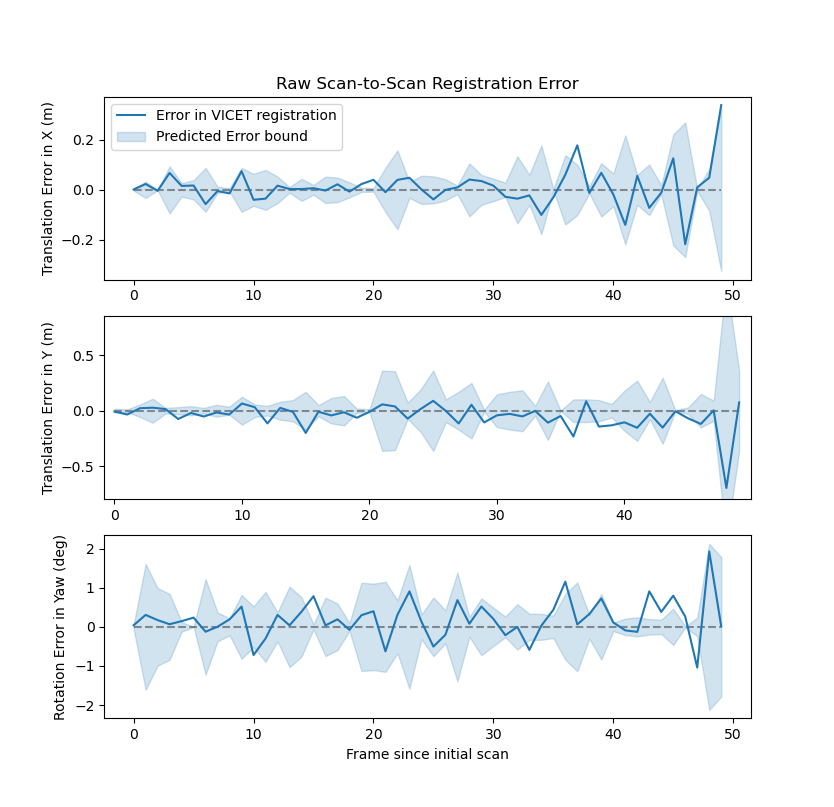

Text(0, 0.5, 'Rotation Error in Yaw (deg)')

In [339]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(3,1)
ax[0].set_title("Raw Scan-to-Scan Registration Error")
ax[0].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:,0], label = 'Error in VICET registration', color = 'C0')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,6]),
                y2 = -abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[0].set_xlabel("Frame since keyframe scan")
ax[0].set_ylabel("Translation Error in X (m)")
ax[0].legend(loc = 'best')

ax[1].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:,1], label = 'Error in VICET registration', color = "C0")
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,7]),
                y2 = -abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[1].set_xlabel("Frame since initial scan")
ax[1].set_ylabel("Translation Error in Y (m)")
# ax[1].legend(loc = 'best')

ax[2].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[2].plot(np.rad2deg(A_hist[:,5]), label = 'Error in VICET registration', color = "C0")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(np.rad2deg(A_hist[:,11])),
                y2 = -abs(np.rad2deg(A_hist[:,11])), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
ax[2].set_xlabel("Frame since initial scan")
ax[2].set_ylabel("Rotation Error in Yaw (deg)")
# ax[2].legend(loc = 'best')

# np.save("results/VICET/VICET_constant_keyframe_05_start_from_1800_v1", A_hist)

In [ ]:
#TODO: compare with LOAM errors for frames 1800-1850:
